# Введение: Идея и подход к решению задачи

**Цель**: Создать модель, которая проверяет, правильно ли указан тип товара (например, "Кружка" для кружки или "Футболка" для футболки) по названию (`name`), типу (`type`) и целевой переменной (`target`).

**Концепция**:
- **Модель 1** (логистическая регрессия): объединяет `name` и `type` через TF-IDF и предсказывает вероятность правильности типа (`P(target=1)`).
- **Модель 2** (логистическая регрессия): предсказывает категорию (`category_l2`, например, "Одежда") по `name` для строк с `target=1`.
- **Словарь**: пары `{category_l2, type}` из строк с `target=1` для проверки, есть ли тип в категории.
- Логика: Модель 1 дает вероятность, Модель 2 предсказывает категорию, а словарь проверяет тип (если вероятность категории ≥ 0.8). Это позволяет уверенно отвергать неверные типы (например, "Пирог" для ножниц), но для подтверждения нужна более серьезная проверка.

**Анализ данных**:
- При `target=1` столбец `category_l2` всегда верный, при `target=0` — встречаются ошибки. Похоже, `category_l2` проставляется после верификации товара, поэтому не использовали его для Модели 1.

**Предобработка**:
- Очищали `name` и `type` от спецсимволов, чисел и стоп-слов ("для", "и", "по") с помощью функции `clean_text`.
- Пробовали лемматизацию (`pymorphy3`), но она искажала смысл (например, "трусы" → "трус", "боксеры" → "боксер") и не дала сильного прироста качества, поэтому убрали.
- Использовали TF-IDF с параметрами `max_features=20000`, `ngram_range=(1, 3)`,  для векторизации текста.

**Выходные данные**:
- Для нового товара (`name`, `type`):
  - Вероятность `P(target=1)` от Модели 1.
  - Предсказанная `category_l2` с вероятностью от Модели 2.
  - Проверка: есть ли тип в словаре для категории.
  - Ответ: "Верно" или "Неверно" (порог 0.8).
- Пример: "Комплект трусов боксеры, 3 шт" с типом "Комплект трусов" — `P(target=1)=0.471`, категория "Одежда" (0.963), тип в словаре, ответ "Верно".

**Тонкости и проблемы**:
- Конкатенация `name` и `type` путала модель: "Футболка" и "Комплект трусов" давали похожие вероятности из-за пересечения слов.
- Модель 2 иногда плохо предсказывала `category_l2`, снижая точность проверки по словарю, из-за большого количества пропусков.

**Итог**:
Модель с TF-IDF и конкатенацией проверяла типы через вероятности и словарь. Работала сносно, но путалась в похожих типах. В будущем можно добавить нейросеть для анализа изображений (например, ResNet), чтобы комбинировать текст и картинки для точной проверки типа.


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Загрузка данных
data_train = pd.read_parquet('hackaton_train_types_recom.parquet').reset_index(drop=True)
data_test = pd.read_parquet('hackaton_test_types_recom.parquet').reset_index(drop=True)

# Проверка первых строк
print("Train data shape:", data_train.shape)
print("Test data shape:", data_test.shape)
print("\nTrain data head:")
display(data_train.head())
print("\nTest data head:")
display(data_test.head())

Train data shape: (763013, 8)
Test data shape: (190754, 8)

Train data head:


,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
0,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
1,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
3,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
4,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0



Test data head:


,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
0,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,None,None,False,1,nan_False_1
1,https://cdn1.ozone.ru/s3/multimedia-1-h/714445...,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Кружка,False,1,Дом и сад_False_1
2,https://cdn1.ozone.ru/s3/multimedia-1-q/719594...,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,True,1,Строительство и ремонт_True_1
3,https://cdn1.ozone.ru/s3/multimedia-1-w/722827...,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,Картина,False,1,Дом и сад_False_1
4,https://cdn1.ozone.ru/s3/multimedia-1-3/696992...,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0


In [ ]:
# Проверка пропусков
print("\nПропуски в train:")
print(data_train.isnull().sum())
print("\nПропуски в test:")
print(data_test.isnull().sum())

# Распределение target
print("\nРаспределение target в train:")
print(data_train['target'].value_counts(normalize=True))

# Количество уникальных типов и категорий
print("\nУникальные type в train:", data_train['type'].nunique())
print("Уникальные category_l2 в train:", data_train['category_l2'].nunique())


Пропуски в train:
main_photo              0
name                    0
type                    0
category_l2        320606
category_l4        320606
is_markup               0
target                  0
stratify_column         0
dtype: int64

Пропуски в test:
main_photo             0
name                   0
type                   0
category_l2        80151
category_l4        80151
is_markup              0
target                 0
stratify_column        0
dtype: int64

Распределение target в train:
target
1    0.503145
0    0.496855
Name: proportion, dtype: float64

Уникальные type в train: 19981
Уникальные category_l2 в train: 28


Комментарий: Проверяем пропуски в данных, распределение target (чтобы оценить дисбаланс классов) и количество уникальных type и category_l2. Это даст представление о данных и поможет выявить проблемы (например, много пропусков или редких категорий).

In [ ]:
def clean_text(text):
    """
    Очищает текст: удаляет все специальные символы и числа.
    Args:
        text (str): Входной текст.
    Returns:
        str: Очищенный текст.
    """
    if not isinstance(text, str):
        return ''

    # Приводим к нижнему регистру
    text = text.lower()

    # Удаляем все специальные символы, оставляем только буквы, цифры и пробелы
    text = re.sub(r'[^\w\s]', ' ', text)

    # Удаляем все числа
    text = re.sub(r'\d+', '', text)

    text = ' '.join([w for w in text.split() if w not in stop_words])

    return text


Определяет функцию clean_text для предобработки текста: приводит к нижнему регистру, убирает спецсимволы, числа и стоп-слова (например, "для", "и"). Используется для name и type.

In [ ]:
# Заполняем пропуски в category_l2
data_train['category_l2'] = data_train['category_l2'].fillna('unknown')
data_test['category_l2'] = data_test['category_l2'].fillna('unknown')

# Очистка и лемматизация текстов (без чисел и спецсимволов)
data_train['clean_name'] = data_train['name'].apply(clean_text)
data_test['clean_name'] = data_test['name'].apply(clean_text)
data_train['clean_type'] = data_train['type'].apply(clean_text)
data_test['clean_type'] = data_test['type'].apply(clean_text)


# Проверка результата
print("\nПример предобработки:")
display(data_train[['name', 'clean_name', 'type', 'clean_type']].head())


Пример предобработки:


,name,clean_name,type,clean_type
0,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,фильтр акпп hyundai getz elantra matrix kia ri...,Ремкомплект двигателя мототехники,ремкомплект двигателя мототехники
1,"Масло оливковое Urzante Light рафинированное, ...",масло оливковое urzante light рафинированное д...,Растительное масло,растительное масло
2,Свитшот Reebok Cl A Crew,свитшот reebok cl a crew,Оповещатель,оповещатель
3,Клин съемник для снятия пластика в авто,клин съемник снятия пластика авто,Съемник,съемник
4,HXD Пыльник,hxd пыльник,Олимпийка,олимпийка


Заполняет пропуски в category_l2 значением "unknown", очищает name и type с помощью clean_text. Выводит примеры для проверки.

In [ ]:
# Создание словаря допустимых пар {category_l2, type} на основе target=1 и category_l2 != "unknown"
valid_pairs = data_train[(data_train['target'] == 1) & (data_train['category_l2'] != 'unknown')][['category_l2', 'type']].drop_duplicates()
valid_pairs_dict = valid_pairs.groupby('category_l2')['type'].apply(list).to_dict()

# Фильтрация пар по частоте (≥ 5 вхождений)
pair_counts = data_train[(data_train['target'] == 1) & (data_train['category_l2'] != 'unknown')].groupby(['category_l2', 'type']).size().reset_index(name='count')
frequent_pairs = pair_counts[pair_counts['count'] >= 5][['category_l2', 'type']]
frequent_pairs_dict = frequent_pairs.groupby('category_l2')['type'].apply(list).to_dict()

# Проверка словаря
print("\nПример словаря (частые пары, ≥ 5 вхождений):")
for cat, types in list(frequent_pairs_dict.items())[:5]:
    print(f"{cat}: {types[:5]}")


Пример словаря (частые пары, ≥ 5 вхождений):
Автомототехника: ['Автомобиль новый', 'Автомобиль с пробегом', 'Аренда автомобиля', 'Машинка', 'Мотоцикл детский']
Автотовары: ['Абразивная паста', 'Автомагнитола', 'Автомобильная подушка', 'Автомобильная фара', 'Автомобильная щетка']
Антиквариат и коллекционирование: ['Альбом коллекционера', 'Блюдо винтажное', 'Галантерея антикварная/винтажная', 'Гравюра антикварная', 'Гравюра винтажная']
Аптека: ['Автомобильная аптечка', 'Аксессуар для протеза', 'Аксессуар для слухового аппарата', 'Аминокислотный комплекс', 'Антиоксидант']
Бытовая техника: ['Автоматическая кофемашина', 'Автоматическая плойка', 'Аквадистиллятор', 'Аксессуар для вакууматора', 'Аксессуар для вентилятора']


Создает словарь {category_l2, type} из строк с target=1, исключая "unknown". Фильтрует типы, составляющие >20% в категории, чтобы уменьшить влияние частых типов (например, "Картина"). Добавляет веса типов (1/частота) для проверки.

In [ ]:
# Объединяем lemmatized_name и lemmatized_type для TF-IDF
data_train['text_input'] = data_train['clean_name'] + ' ' + data_train['clean_type']
data_test['text_input'] = data_test['clean_name'] + ' ' + data_test['clean_type']

# Проверка
print("\nПример text_input:")
print(data_train[['text_input']].head())


Пример text_input:
                                          text_input
0  фильтр акпп hyundai getz elantra matrix kia ri...
1  масло оливковое urzante light рафинированное д...
2               свитшот reebok cl a crew оповещатель
3          клин съемник снятия пластика авто съемник
4                              hxd пыльник олимпийка


Объединяет очищенные clean_name и clean_type в text_input для последующей векторизации TF-IDF.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Кодирование category_l2 с помощью OneHotEncoder
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
category_l2_train = encoder.fit_transform(data_train[['category_l2']])
category_l2_test = encoder.transform(data_test[['category_l2']])

# Преобразуем в DataFrame для удобства
category_l2_train_df = pd.DataFrame.sparse.from_spmatrix(
    category_l2_train,
    columns=encoder.get_feature_names_out(['category_l2']),
    index=data_train.index
)
category_l2_test_df = pd.DataFrame.sparse.from_spmatrix(
    category_l2_test,
    columns=encoder.get_feature_names_out(['category_l2']),
    index=data_test.index
)

# Проверка
print("\nРазмер category_l2_train_df:", category_l2_train_df.shape)
print("Пример закодированных category_l2 (train):")
display(category_l2_train_df.head())


Размер category_l2_train_df: (763013, 29)
Пример закодированных category_l2 (train):


,category_l2_unknown,category_l2_Автомототехника,category_l2_Автотовары,category_l2_Антиквариат и коллекционирование,category_l2_Аптека,category_l2_Бытовая техника,category_l2_Бытовая химия,category_l2_Галантерея и аксессуары,category_l2_Детские товары,category_l2_Дом и сад,...,category_l2_Продукты питания Ozon Fresh,category_l2_Спорт и отдых,category_l2_Строительство и ремонт,category_l2_Товары для взрослых,category_l2_Товары для животных,category_l2_Товары для курения и аксессуары,category_l2_Фермерское хозяйство,category_l2_Хобби и творчество,category_l2_Электроника,category_l2_Ювелирные изделия
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Кодирует category_l2 в one-hot формат

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

# TF-IDF для clean_name
tfidf_name = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), min_df=5, stop_words=stop_words)
tfidf_name_train = tfidf_name.fit_transform(data_train['clean_name'])
tfidf_name_test = tfidf_name.transform(data_test['clean_name'])

tfidf_name_train_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_name_train,
    columns=[f'tfidf_name_{i}' for i in range(tfidf_name_train.shape[1])],
    index=data_train.index
)
tfidf_name_test_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_name_test,
    columns=[f'tfidf_name_{i}' for i in range(tfidf_name_test.shape[1])],
    index=data_test.index
)

# TF-IDF для clean_type
tfidf_type = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), stop_words=stop_words)
tfidf_type_train = tfidf_type.fit_transform(data_train['clean_type'])
tfidf_type_test = tfidf_type.transform(data_test['clean_type'])

tfidf_type_train_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_type_train,
    columns=[f'tfidf_type_{i}' for i in range(tfidf_type_train.shape[1])],
    index=data_train.index
)
tfidf_type_test_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_type_test,
    columns=[f'tfidf_type_{i}' for i in range(tfidf_type_test.shape[1])],
    index=data_test.index
)

# Проверка
print("\nРазмер TF-IDF name (train):", tfidf_name_train_df.shape)
print("\nРазмер TF-IDF type (train):", tfidf_type_train_df.shape)


Размер TF-IDF name (train): (763013, 20000)

Размер TF-IDF type (train): (763013, 20000)


Создает TF-IDF векторы для clean_name и clean_type

In [ ]:
# Объединяем TF-IDF и category_l2 для варианта 1
X_train = pd.concat([tfidf_name_train_df, tfidf_type_train_df, category_l2_train_df], axis=1)
X_test = pd.concat([tfidf_name_test_df, tfidf_type_test_df, category_l2_test_df], axis=1)

# Целевая переменная
y_train = data_train['target']

# Проверка
print("\nРазмер X_train (вариант 1):", X_train.shape)
print("Размер X_test (вариант 1):", X_test.shape)
print("Пример X_train (вариант 1):")
display(X_train.head())


Размер X_train (вариант 1): (763013, 40029)
Размер X_test (вариант 1): (190754, 40029)
Пример X_train (вариант 1):


,tfidf_name_0,tfidf_name_1,tfidf_name_2,tfidf_name_3,tfidf_name_4,tfidf_name_5,tfidf_name_6,tfidf_name_7,tfidf_name_8,tfidf_name_9,...,category_l2_Продукты питания Ozon Fresh,category_l2_Спорт и отдых,category_l2_Строительство и ремонт,category_l2_Товары для взрослых,category_l2_Товары для животных,category_l2_Товары для курения и аксессуары,category_l2_Фермерское хозяйство,category_l2_Хобби и творчество,category_l2_Электроника,category_l2_Ювелирные изделия
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Объединяет TF-IDF признаки для name, type и one-hot category_l2.

In [ ]:


# Фильтрация данных
data_train_target1 = data_train[(data_train['target'] == 1) & (data_train['category_l2'] != 'unknown')].copy()

# TF-IDF для clean_name
tfidf_name = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), min_df=5, stop_words=stop_words)
tfidf_name_train = tfidf_name.fit_transform(data_train_target1['clean_name'])
tfidf_name_test = tfidf_name.transform(data_test['clean_name'])

tfidf_name_train_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_name_train,
    columns=[f'tfidf_name_{i}' for i in range(tfidf_name_train.shape[1])],
    index=data_train_target1.index
)
tfidf_name_test_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_name_test,
    columns=[f'tfidf_name_{i}' for i in range(tfidf_name_test.shape[1])],
    index=data_test.index
)

y_train_category = data_train_target1['category_l2']

# Проверка
print("\nРазмер данных для Модели 2 (train):", tfidf_name_train_df.shape)


Размер данных для Модели 2 (train): (287816, 20000)


Фильтрует данные с target=1 и category_l2 != "unknown".

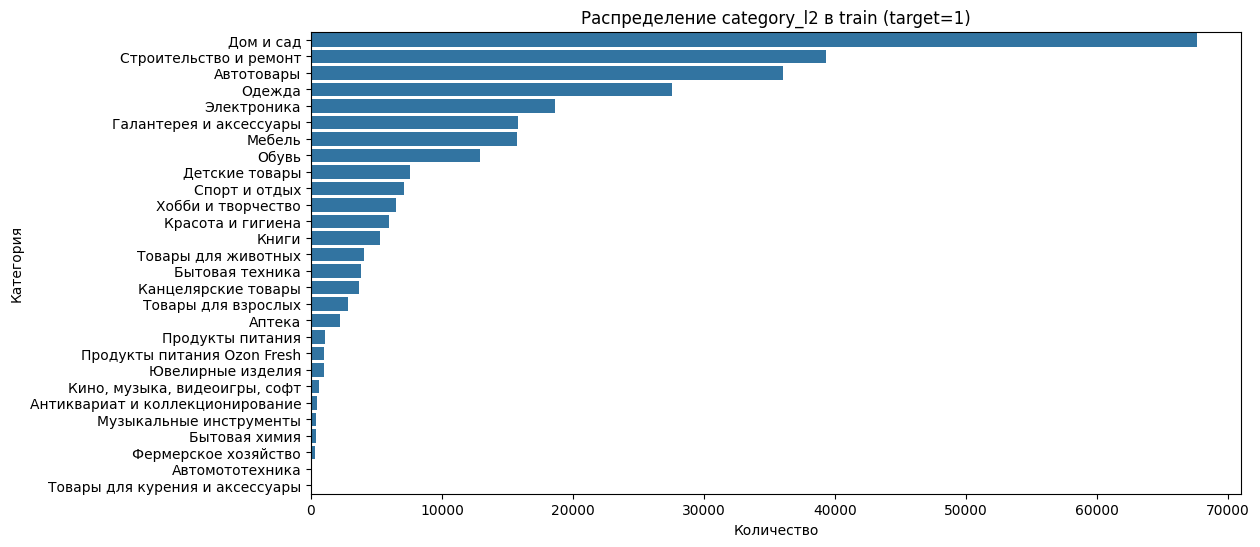

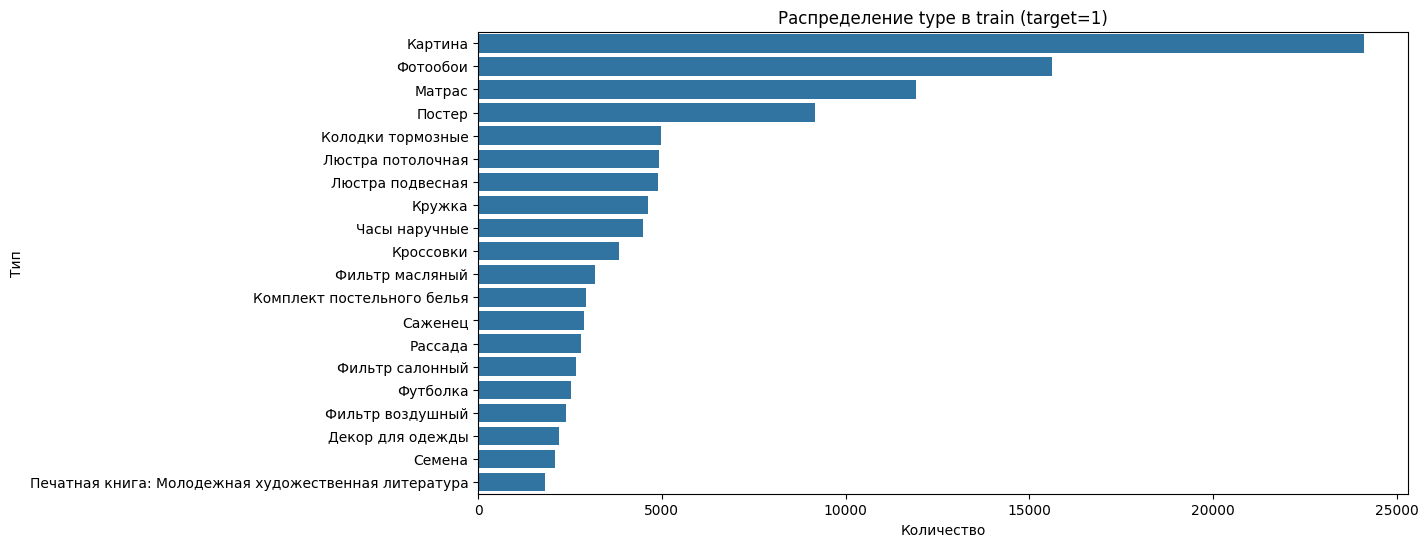

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение category_l2 в train (target=1)
plt.figure(figsize=(12, 6))
sns.countplot(y=data_train_target1['category_l2'], order=data_train_target1['category_l2'].value_counts().index)
plt.title('Распределение category_l2 в train (target=1)')
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.show()

# Распределение type в train (target=1)
top_types = data_train_target1['type'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_types.values,
    y=top_types.index,
)
plt.title('Распределение type в train (target=1)')
plt.xlabel('Количество')
plt.ylabel('Тип')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Обучение Модели 1
model1 = LogisticRegression(max_iter=1000, random_state=42)
model1.fit(X_train, y_train)

# Предсказания на test
y_pred_proba = model1.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC
if 'target' in data_test.columns:
    roc_auc = roc_auc_score(data_test['target'], y_pred_proba)
    print("\nROC-AUC для Модели 1:", roc_auc)
else:
    print("\nПредсказанные вероятности для Модели 1:")
    print(y_pred_proba[:5])

# Сохранение предсказаний
data_test['pred_proba_model1'] = y_pred_proba

# Проверка
print("\nПример предсказаний Модели 1:")
display(data_test[['name', 'type', 'category_l2', 'pred_proba_model1']].head())


ROC-AUC для Модели 1: 0.8808504094109081

Пример предсказаний Модели 1:


,name,type,category_l2,pred_proba_model1
0,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,unknown,0.318391
1,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,0.995147
2,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,0.420730
3,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,0.999114
4,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,0.084896


Обучает логистическую регрессию

In [ ]:
# Обучение Модели 2 (многоклассовая классификация для category_l2)
model2 = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
model2.fit(tfidf_name_train_df, y_train_category)

# Предсказания вероятностей на test
category_probs = model2.predict_proba(tfidf_name_test_df)
category_probs_df = pd.DataFrame(
    category_probs,
    columns=model2.classes_,
    index=data_test.index
)

# Находим наиболее вероятную категорию
data_test['pred_category_l2'] = model2.predict(tfidf_name_test_df)

# Проверка
print("\nПример предсказаний Модели 2:")
display(data_test[['name', 'pred_category_l2']].head())
print("\nВероятности для 5 категорий:")
display(category_probs_df.iloc[:, :5].head())


Пример предсказаний Модели 2:


,name,pred_category_l2
0,"Защитный кейс (бокс, чехол) для карт памяти SD...",Электроника
1,Кружка латте керамическая большая для чая и ко...,Дом и сад
2,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Строительство и ремонт
3,"Интерьерная картина ""Кирпичи в руинах древней ...",Дом и сад
4,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Хобби и творчество



Вероятности для 5 категорий:


,Автомототехника,Автотовары,Антиквариат и коллекционирование,Аптека,Бытовая техника
0,0.000169,0.030586,0.001175,0.002133,0.003170
1,0.000023,0.000609,0.000167,0.000668,0.000429
2,0.000325,0.011481,0.001283,0.005124,0.016411
3,0.000013,0.000407,0.000060,0.000211,0.000239
4,0.000124,0.001867,0.000851,0.002353,0.001577


In [ ]:
# Функция для проверки типа по словарю с порогом уверенности
def check_type_in_category(row, pairs_dict, category_probs_df, threshold=0.8):
    pred_category = row['pred_category_l2']
    type_ = row['type']
    # Получаем вероятность для предсказанной категории
    if pred_category in category_probs_df.columns:
        prob = category_probs_df.loc[row.name, pred_category]
        # Проверяем порог уверенности и наличие типа в словаре
        if prob >= threshold and pred_category in pairs_dict and type_ in pairs_dict[pred_category]:
            return 1
    return 0

# Применяем проверку
data_test['type_valid'] = data_test.apply(
    lambda row: check_type_in_category(row, frequent_pairs_dict, category_probs_df, threshold=0.8),
    axis=1
)

# Проверка
print("\nПример проверки по словарю:")
display(data_test[['name', 'type', 'pred_category_l2', 'type_valid']].head())
print("\nДоля валидных типов:", data_test['type_valid'].mean())


Пример проверки по словарю:


,name,type,pred_category_l2,type_valid
0,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,Электроника,1
1,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,1
2,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,0
3,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,1
4,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,0



Доля валидных типов: 0.3327059983014773


Проверяет, есть ли тип в словаре для предсказанной категории с учетом порога (0.8).

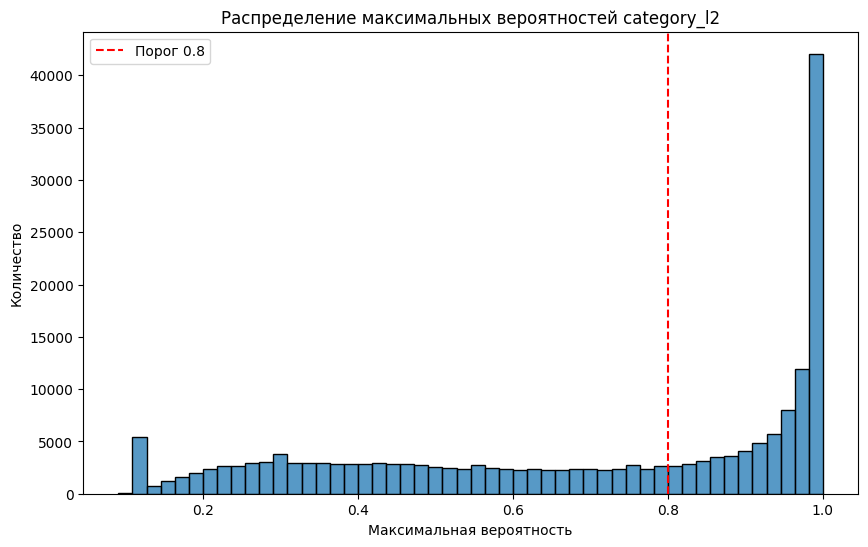


Доля предсказаний category_l2 с вероятностью >= 0.8: 0.4840527590509242


In [ ]:
# Получаем максимальные вероятности для pred_category_l2
max_probs = category_probs_df.max(axis=1)

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.histplot(max_probs, bins=50)
plt.axvline(0.8, color='red', linestyle='--', label='Порог 0.8')
plt.title('Распределение максимальных вероятностей category_l2')
plt.xlabel('Максимальная вероятность')
plt.ylabel('Количество')
plt.legend()
plt.show()

# Доля предсказаний выше порога
print("\nДоля предсказаний category_l2 с вероятностью >= 0.8:", (max_probs >= 0.8).mean())


Комбинированные результаты:


,name,type,category_l2,pred_category_l2,pred_proba_model1,type_valid
0,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,unknown,Электроника,0.318391,1
1,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Дом и сад,0.995147,1
2,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Строительство и ремонт,0.420730,0
3,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,Дом и сад,0.999114,1
4,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Хобби и творчество,0.084896,0


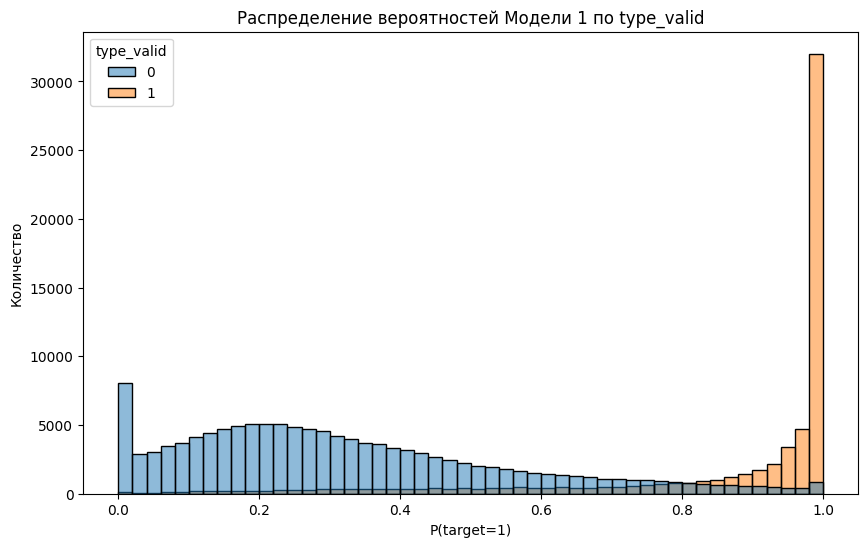


Корреляция между P(target=1) и type_valid: 0.7440636825195848


In [ ]:
# Объединяем результаты Модели 1 и проверки по словарю
results = data_test[['name', 'type', 'category_l2', 'pred_category_l2', 'pred_proba_model1', 'type_valid']].copy()

# Выводим результаты
print("\nКомбинированные результаты:")
display(results.head())

# Визуализация: распределение вероятностей по type_valid
plt.figure(figsize=(10, 6))
sns.histplot(data=results, x='pred_proba_model1', hue='type_valid', bins=50, alpha=0.5)
plt.title('Распределение вероятностей Модели 1 по type_valid')
plt.xlabel('P(target=1)')
plt.ylabel('Количество')
plt.show()

# Корреляция между pred_proba_model1 и type_valid
print("\nКорреляция между P(target=1) и type_valid:",
      results['pred_proba_model1'].corr(results['type_valid']))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

def evaluate_new_item(name, type_, model1, model2, tfidf_name, tfidf_type, encoder, pairs_dict, pair_counts, threshold=0.8):
    # DataFrame для нового товара
    new_item = pd.DataFrame({'name': [name], 'type': [type_], 'category_l2': ['unknown']})

    # Очистка текста
    new_item['clean_name'] = new_item['name'].apply(clean_text)
    new_item['clean_type'] = new_item['type'].apply(clean_text)

    # Отладка
    print("\nОтладка: clean_name =", new_item['clean_name'].iloc[0])
    print("Отладка: clean_type =", new_item['clean_type'].iloc[0])

    # TF-IDF для Модели 1
    tfidf_name_new = tfidf_name.transform(new_item['clean_name'])
    tfidf_type_new = tfidf_type.transform(new_item['clean_type'])
    tfidf_name_new_df = pd.DataFrame.sparse.from_spmatrix(
        tfidf_name_new,
        columns=[f'tfidf_name_{i}' for i in range(tfidf_name_new.shape[1])]
    )
    tfidf_type_new_df = pd.DataFrame.sparse.from_spmatrix(
        tfidf_type_new,
        columns=[f'tfidf_type_{i}' for i in range(tfidf_type_new.shape[1])]
    )

    # Кодирование category_l2
    category_l2_new = encoder.transform(new_item[['category_l2']])
    category_l2_new_df = pd.DataFrame.sparse.from_spmatrix(
        category_l2_new,
        columns=encoder.get_feature_names_out(['category_l2'])
    )

    # Признаки для Модели 1
    X_new = pd.concat([tfidf_name_new_df, tfidf_type_new_df, category_l2_new_df], axis=1)

    # Предсказание Модели 1
    prob_model1 = model1.predict_proba(X_new)[:, 1][0]

    # TF-IDF для Модели 2 (используем тот же tfidf_name)
    tfidf_name_new_model2 = tfidf_name.transform(new_item['clean_name'])
    tfidf_name_new_model2_df = pd.DataFrame.sparse.from_spmatrix(
        tfidf_name_new_model2,
        columns=[f'tfidf_name_{i}' for i in range(tfidf_name_new_model2.shape[1])]
    )

    # Предсказание Модели 2
    category_probs = model2.predict_proba(tfidf_name_new_model2_df)
    pred_category = model2.predict(tfidf_name_new_model2_df)[0]
    max_prob = category_probs.max()

    # Проверка по словарю
    type_valid = 1 if (max_prob >= threshold and pred_category in pairs_dict and type_ in pairs_dict[pred_category]) else 0


    # Вывод
    print("\nВведенный товар:", name)
    print("Введенный тип:", type_)
    print(f"Оценка типа (P(target=1)): {prob_model1:.3f}")
    print(f"Предсказанная категория (l2): {pred_category} (вероятность: {max_prob:.3f})")
    print(f"Тип в словаре: {'Да' if pred_category in pairs_dict and type_ in pairs_dict[pred_category] else 'Нет'}")
    print(f"Финальный ответ (с порогом {threshold}): {'Верно' if type_valid == 1 else 'Неверно'}")


    return prob_model1, type_valid, pred_category, max_prob



In [ ]:
# Тестовые примеры
test_cases = [
    ("Комплект трусов боксеры для Veenice Трусы по мужские, от 3 шт", "Комплект трусов"),
    ("Комплект трусов боксеры Veenice Трусы мужские, 3 шт", "Кружка"),
    ("Кружка латте керамическая большая для чая и кофе", "Кружка"),
    ("Ножницы Волна 23 см", "Пирог"),
    ("Комплект трусов боксеры Veenice Трусы мужские, 3 шт", ""),
    ("qwerty трусы", "Комплект трусов"),
    ("qwerty трусы", "Диск тормозной"),
    ("qwerty", "Комплект трусов"),
    ("qwerty трусы", "Фотообои"),
    ("qwerty трусы", "Пирог"),
]

# Запуск тестов
results = []
for name, type_ in test_cases:
    print("\n=== Тест ===")
    prob, valid, category, cat_prob = evaluate_new_item(
        name, type_, model1, model2, tfidf_name, tfidf_type, encoder, frequent_pairs_dict, pair_counts
    )
    results.append({
        'Товар': name,
        'Тип': type_,
        'P(target=1)': prob,
        'Категория': category,
        'P(category_l2)': cat_prob,
        'Тип в словаре': 'Да' if category in frequent_pairs_dict and type_ in frequent_pairs_dict[category] else 'Нет',
        'Ответ': 'Верно' if valid else 'Неверно',
    })

# Вывод результатов
print("\n=== Итоги тестов ===")
display(pd.DataFrame(results))


=== Тест ===

Отладка: clean_name = комплект трусов боксеры veenice трусы мужские шт
Отладка: clean_type = комплект трусов

Введенный товар: Комплект трусов боксеры для Veenice Трусы по мужские, от 3 шт
Введенный тип: Комплект трусов
Оценка типа (P(target=1)): 0.877
Предсказанная категория (l2): Одежда (вероятность: 0.986)
Тип в словаре: Да
Финальный ответ (с порогом 0.8): Верно

=== Тест ===

Отладка: clean_name = комплект трусов боксеры veenice трусы мужские шт
Отладка: clean_type = кружка

Введенный товар: Комплект трусов боксеры Veenice Трусы мужские, 3 шт
Введенный тип: Кружка
Оценка типа (P(target=1)): 0.961
Предсказанная категория (l2): Одежда (вероятность: 0.986)
Тип в словаре: Нет
Финальный ответ (с порогом 0.8): Неверно

=== Тест ===

Отладка: clean_name = кружка латте керамическая большая чая кофе
Отладка: clean_type = кружка

Введенный товар: Кружка латте керамическая большая для чая и кофе
Введенный тип: Кружка
Оценка типа (P(target=1)): 0.887
Предсказанная категория (l2)

,Товар,Тип,P(target=1),Категория,P(category_l2),Тип в словаре,Ответ
0,Комплект трусов боксеры для Veenice Трусы по м...,Комплект трусов,0.877368,Одежда,0.985947,Да,Верно
1,"Комплект трусов боксеры Veenice Трусы мужские,...",Кружка,0.961295,Одежда,0.985947,Нет,Неверно
2,Кружка латте керамическая большая для чая и кофе,Кружка,0.887063,Дом и сад,0.991571,Да,Верно
3,Ножницы Волна 23 см,Пирог,0.052547,Дом и сад,0.326180,Нет,Неверно
4,"Комплект трусов боксеры Veenice Трусы мужские,...",,0.502066,Одежда,0.985947,Нет,Неверно
5,qwerty трусы,Комплект трусов,0.800283,Одежда,0.696960,Да,Неверно
6,qwerty трусы,Диск тормозной,0.854678,Одежда,0.696960,Нет,Неверно
7,qwerty,Комплект трусов,0.672998,Книги,0.123214,Нет,Неверно
8,qwerty трусы,Фотообои,0.999089,Одежда,0.696960,Нет,Неверно
9,qwerty трусы,Пирог,0.074512,Одежда,0.696960,Нет,Неверно
